<a href="https://www.kaggle.com/code/serdargundogdu/gdz-enerji-makine-renmesi-lk-xgboost?scriptVersionId=126212978" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# İş Problemi

İzmir ve Manisa illerinde günlük yaşamın vazgeçilmezi olan elektrik enerjisini, insan odaklı hizmet anlayışı ve modern teknoloji sistemleri ile tüketicilerine ulaştıran Gdz Elektrik, geleneksel hale getirdiği Datathon serisinin ikincisinin çözümüdür.

Katılımcıların sunulan veri seti ile Gdz Elektrik sorumluluğundaki şebeke merkezlerine yönelik "enerji dağıtım" tahminleme yaklaşımı geliştirilmesi bekleniyor. 🎯

Kaggle yarışmasında başarı metriği MAPE (Mean Absolute Percentage Error) olacaktır.

# Veri Seti Hikayesi

Dosya

● med.csv - Major Event Day veri seti

● train.csv - Train veri seti

● sample_submission.csv - Örnek submission dosyası

Açıklamalar

Major Event Day (MED.CSV): Gün içindeki elektrik kesinti süresinin kabul edilebilir limiti aştığı gün. Dolayısıyla kesinti olduysa o gün tahmin edilen enerjinin sapmasının yüksek olmasını bekleriz. Çünkü kesinti nedeniyle dağıtılamamış.

Dağıtılan Enerji: Watt: Aktif(yararlı) gücün birimi. MWh = MegaWatt saat

Dağıtılan Enerji'nin %85'i İzmir, %15'i ise Manisa için gerçekleştirilmektedir.

Dış Veri Kullanımı Size faydalı olabileceğini düşündüğünüz her türlü halka açık veriyi kullanabilirsiniz.

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/train.csv')
df = df.set_index('Tarih')
df.index = pd.to_datetime(df.index)

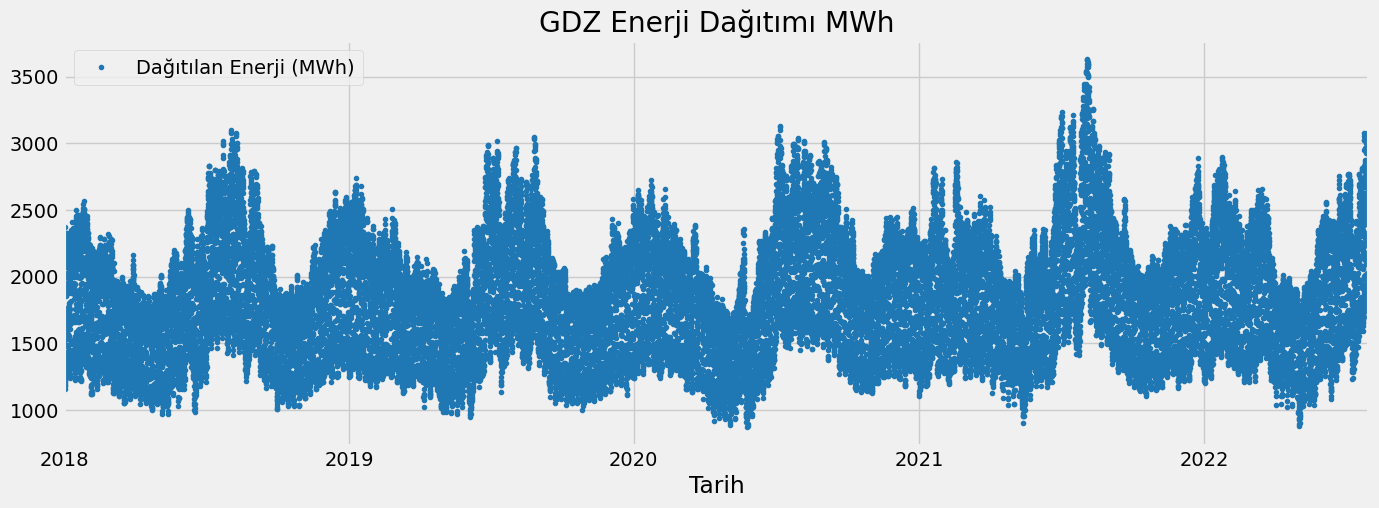

In [3]:
df.plot(style='.', 
        figsize=(15,5), 
        color=color_pal[0], 
        title='GDZ Enerji Dağıtımı MWh')
plt.show()

# Train / Test Split

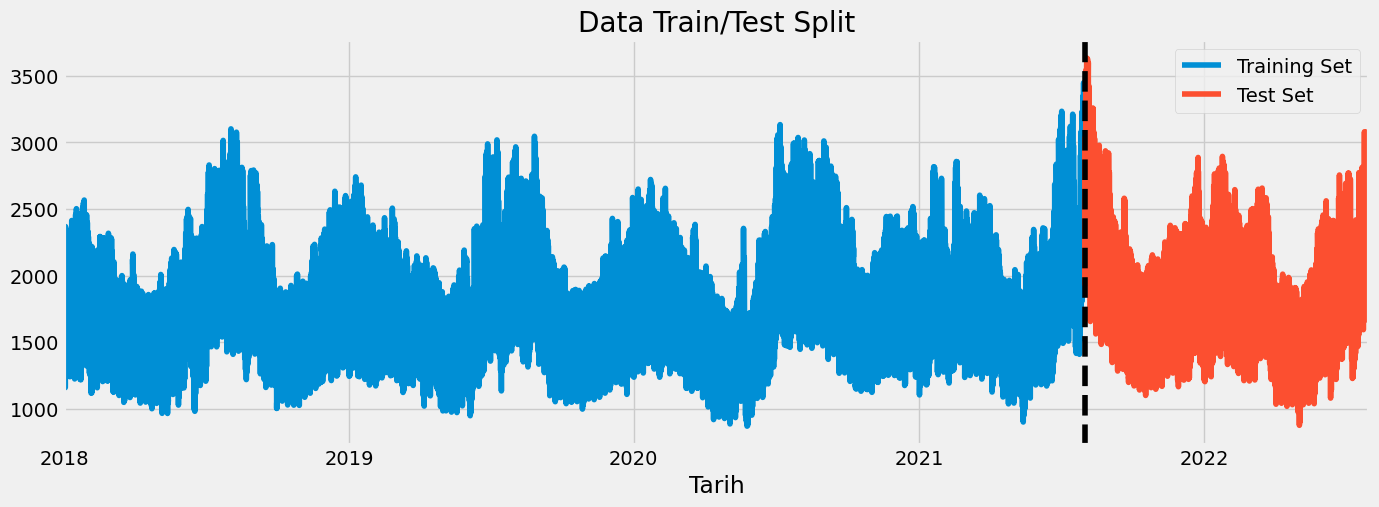

In [4]:
train = df.loc[df.index < '2021-08-01']
test = df.loc[df.index >= '2021-08-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2021-08-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

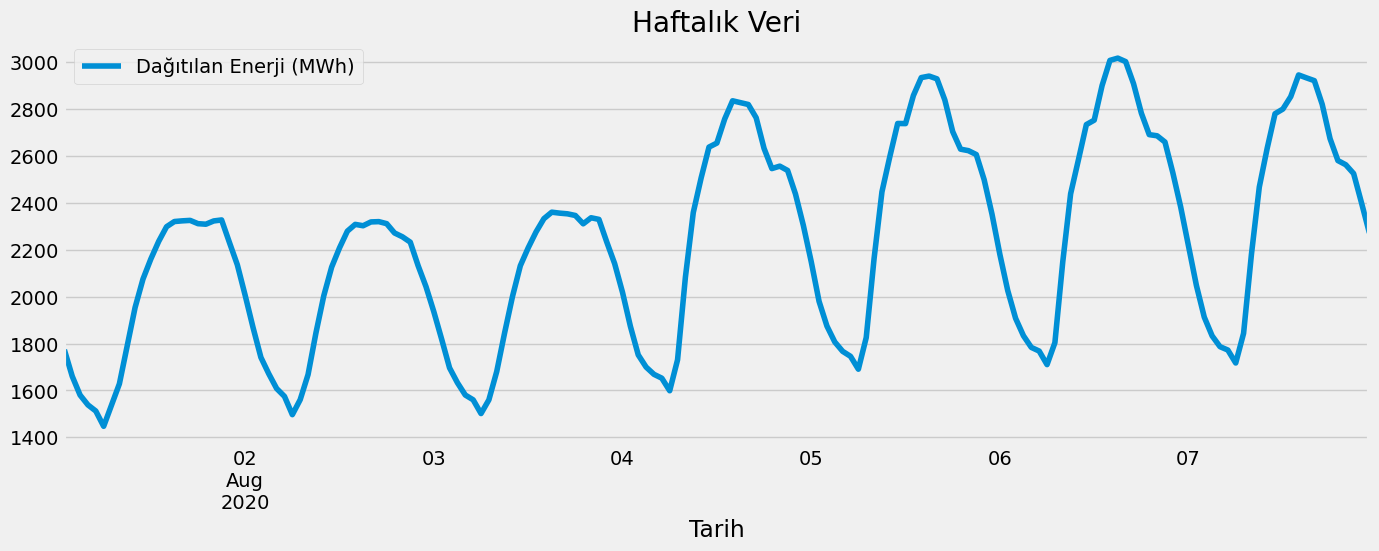

In [5]:
df.loc[(df.index > '2020-08-01') & (df.index < '2020-08-08')].plot(figsize=(15,5), title='Haftalık Veri')
plt.show()

# Özellik Çıkarımı

In [6]:
def create_features(df):
    """
    Create time series features based on time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

# Özellik Hedef İlişkisinin Görselleştirilmesi

Text(0.5, 1.0, 'Saatlik MW')

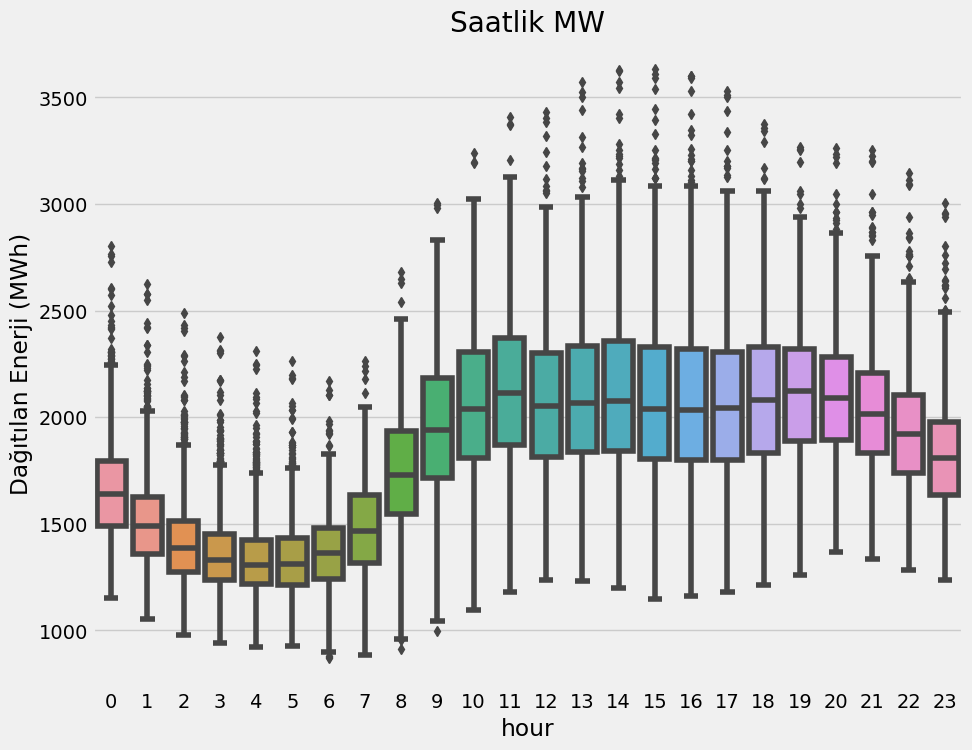

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='Dağıtılan Enerji (MWh)')
ax.set_title('Saatlik MW')

Text(0.5, 1.0, 'Saatlik MW')

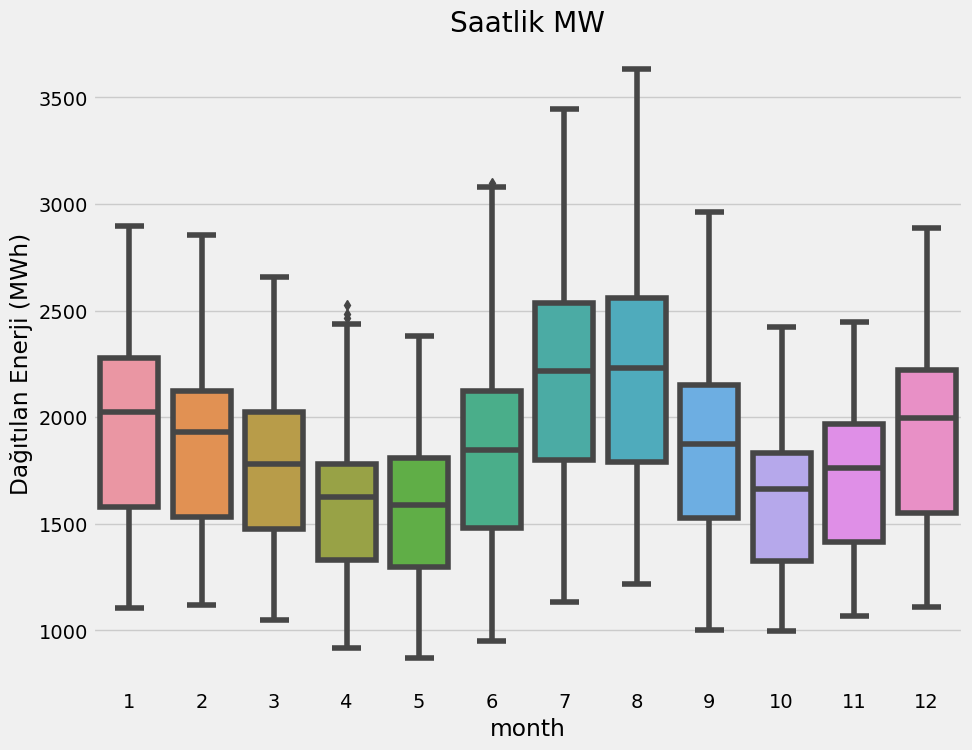

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Dağıtılan Enerji (MWh)')
ax.set_title('Saatlik MW')

# Modelin Oluşturulması

In [9]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = ['Dağıtılan Enerji (MWh)']

In [10]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [11]:
reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,
                       learning_rate = 0.01,
                       eval_metric='mape')
reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100)

[0]	validation_0-mape:0.98963	validation_1-mape:0.98981
[100]	validation_0-mape:0.35723	validation_1-mape:0.36848
[200]	validation_0-mape:0.13080	validation_1-mape:0.13977
[300]	validation_0-mape:0.06382	validation_1-mape:0.07379
[365]	validation_0-mape:0.05216	validation_1-mape:0.07646


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric='mape', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

# Özellik Önem Seviyeleri

In [12]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
            columns=['importance'])

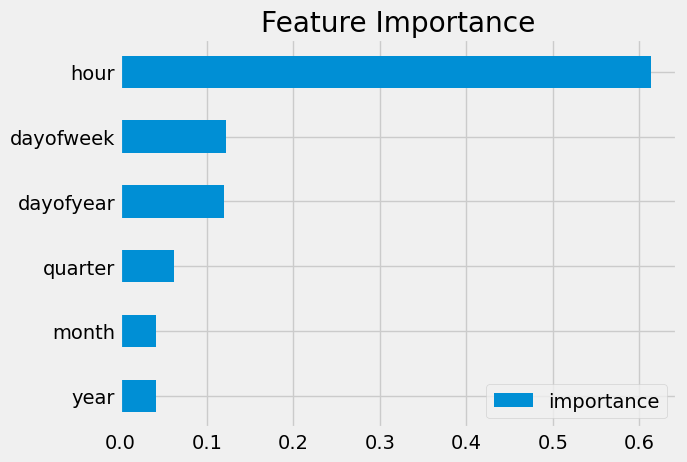

In [13]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Test Veri Seti Üzerinden Tahmin

In [14]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

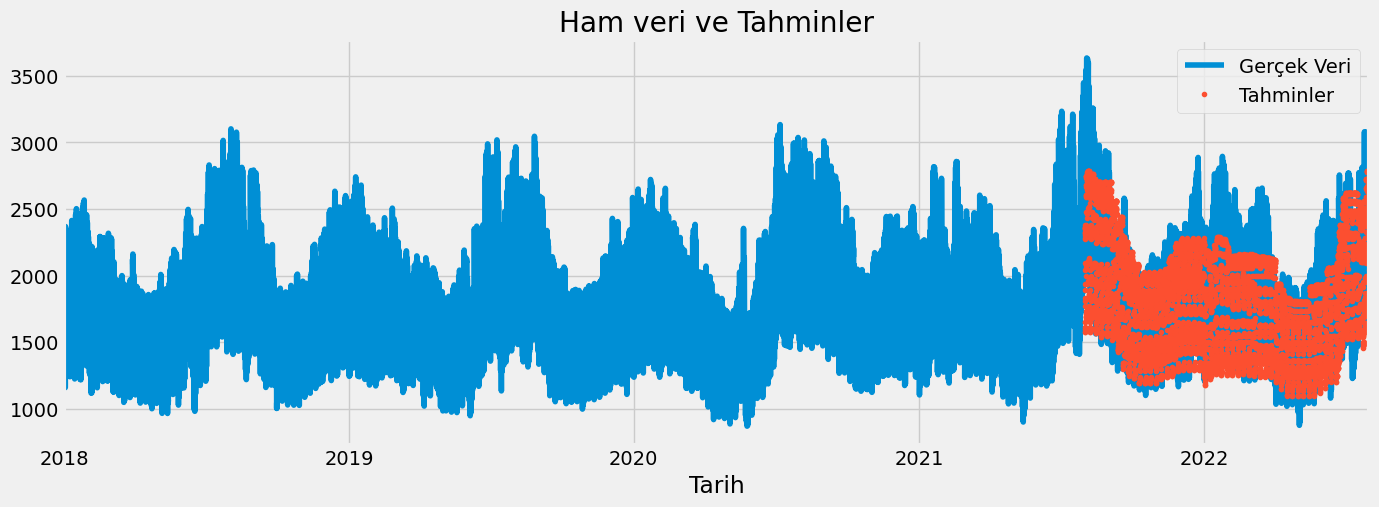

In [15]:
ax = df[['Dağıtılan Enerji (MWh)']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Gerçek Veri', 'Tahminler'])
ax.set_title('Ham veri ve Tahminler')
plt.show()

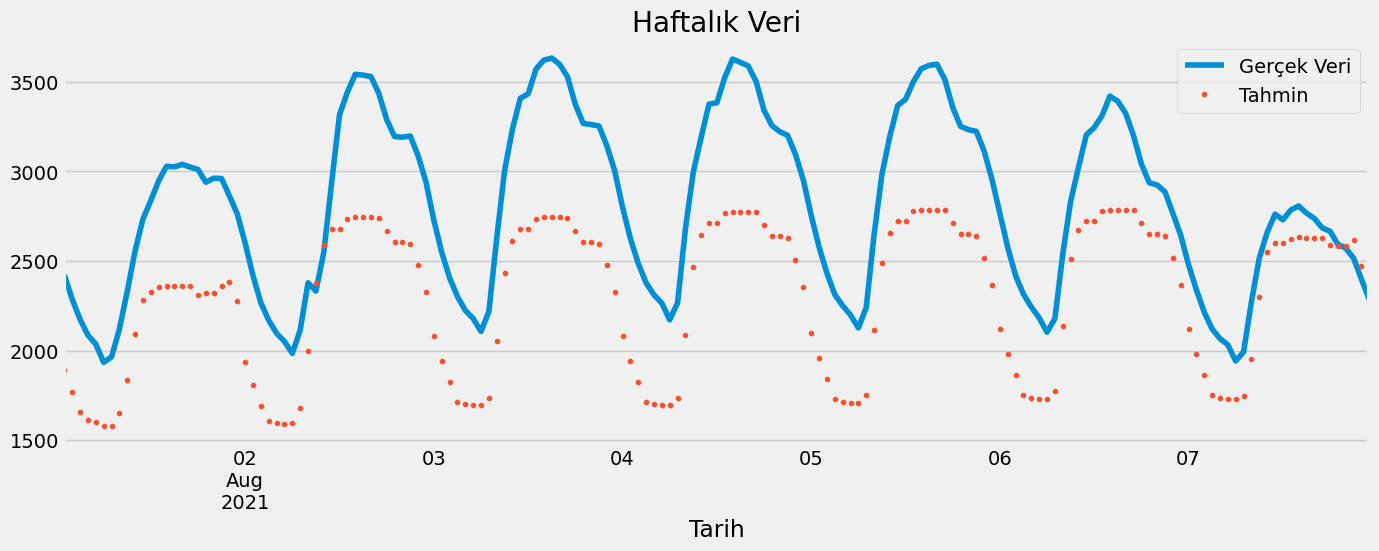

In [16]:
ax = df.loc[(df.index > '2021-08-01') & (df.index < '2021-08-08')]['Dağıtılan Enerji (MWh)'].plot(figsize=(15,5), title='Haftalık Veri')
df.loc[(df.index > '2021-08-01') & (df.index < '2021-08-08')]['prediction'].plot(style='.')
plt.legend(['Gerçek Veri', 'Tahmin'])
plt.show()

In [17]:
score = mean_absolute_percentage_error(test['Dağıtılan Enerji (MWh)'], test['prediction'])
print(f'MAPE skoru {score: 0.4}')

MAPE skoru  0.0731


# Hata Hesaplama

* En iyi ve en kötü tahminli günleri bulma

In [18]:
test['error'] = np.abs(test['Dağıtılan Enerji (MWh)'] - test['prediction'])

In [19]:
test['date'] = test.index.date

In [20]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head()

date
2021-08-03    660.854830
2021-08-04    646.539404
2021-08-05    614.347195
2021-08-02    540.085985
2021-08-01    539.613534
Name: error, dtype: float64

In [21]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head()

date
2022-04-25    29.623586
2022-04-15    31.380992
2022-04-29    31.523951
2022-04-22    32.074491
2022-01-07    32.231490
Name: error, dtype: float64

In [22]:
test['error'] = np.abs(test['Dağıtılan Enerji (MWh)'] - test['prediction'])
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=False).head(10)

date
2021-08-03    660.854830
2021-08-04    646.539404
2021-08-05    614.347195
2021-08-02    540.085985
2021-08-01    539.613534
2022-07-11    512.178792
2022-07-12    469.058750
2022-07-09    467.845773
2021-08-06    440.736273
2022-05-03    425.290427
Name: error, dtype: float64

# Bir dahaki adımda

- Daha robust cross validation
- Daha çok özellik eklemek (Hava durumu, tatiller)

# Kaynakça

https://www.youtube.com/watch?v=vV12dGe_Fho&ab_channel=RobMulla